In [1]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../../src/models")

from predict import CarCountingModel as Model
from dataset import CowcDataset_Counting

/opt/conda/envs/py3.6/lib/python3.6/site-packages/cupy/core/fusion.py:659: FutureWarning: cupy.core.fusion is experimental. The interface can change in the future.
  util.experimental('cupy.core.fusion')


In [2]:
val_list =  "../../data/cowc_processed/train_val/crop/val.txt"
data_root = "../../data/cowc_processed/train_val/crop/val"
crop_size = 96
car_max = 9
count_ignore_width = 8

dataset = CowcDataset_Counting(val_list, data_root, crop_size, \
                               dtype=np.uint8, transpose_image=False, return_mask=True, count_ignore_width=count_ignore_width, label_max=car_max)

In [3]:
model_path = "../../models/logs/model_iter_85458"
class_num = car_max + 1

mean_path = "../../data/cowc_processed/train_val/crop/mean.npy"
mean = np.load(mean_path)

model = Model(model_path, class_num, crop_size, mean)

In [4]:
def resize_cam(cam, dst_size):
    cam = cv2.resize(cam, (dst_size, dst_size), interpolation=cv2.cv2.INTER_CUBIC)
    cam = cv2.resize(cam, (crop_size, crop_size), interpolation=cv2.INTER_NEAREST)
    
    return cam

# Show CAMs on correctly classified samples

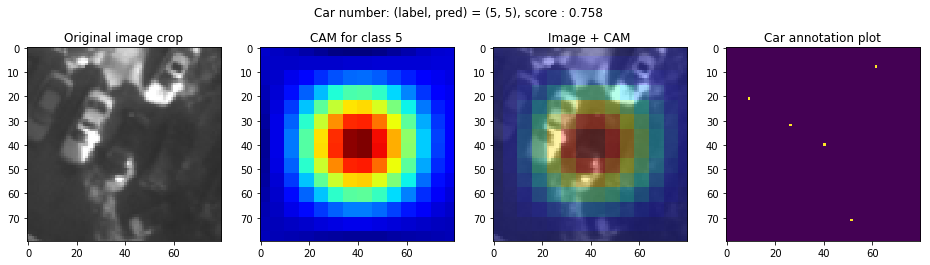

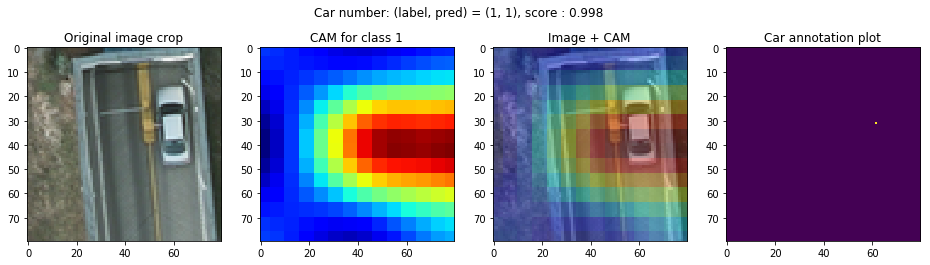

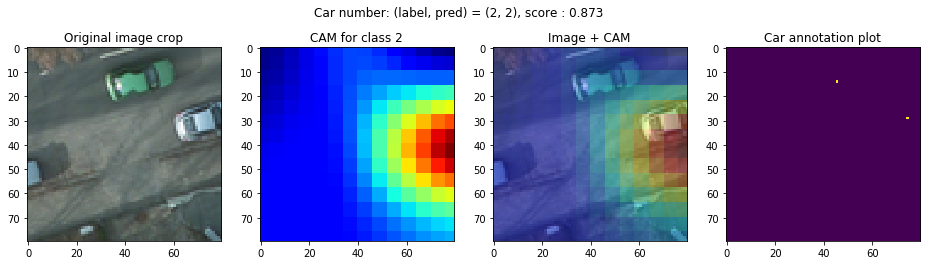

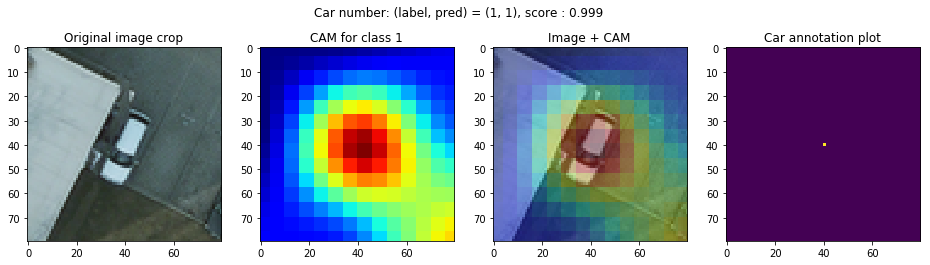

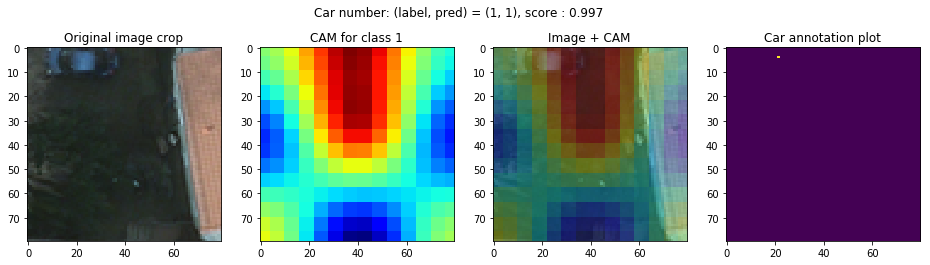

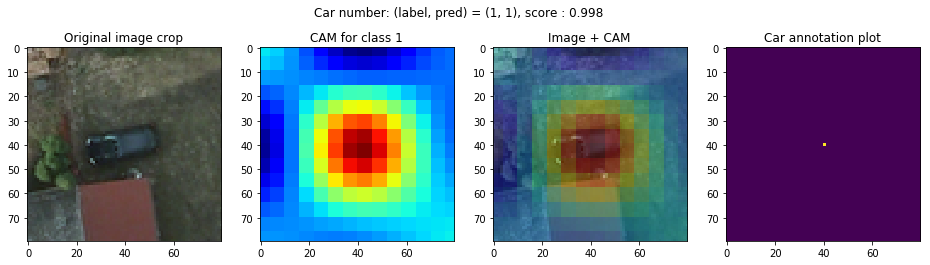

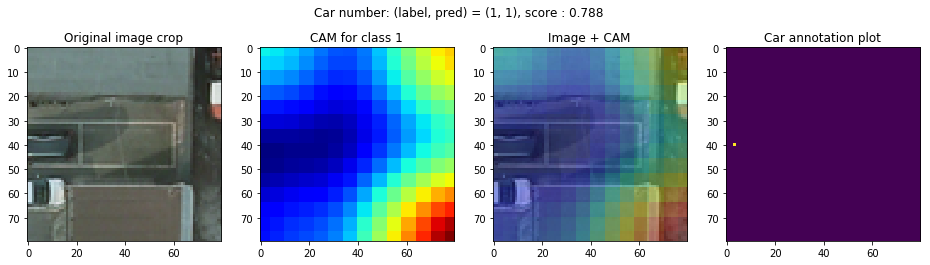

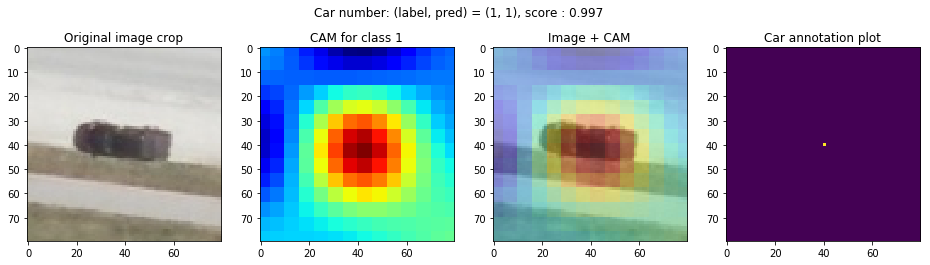

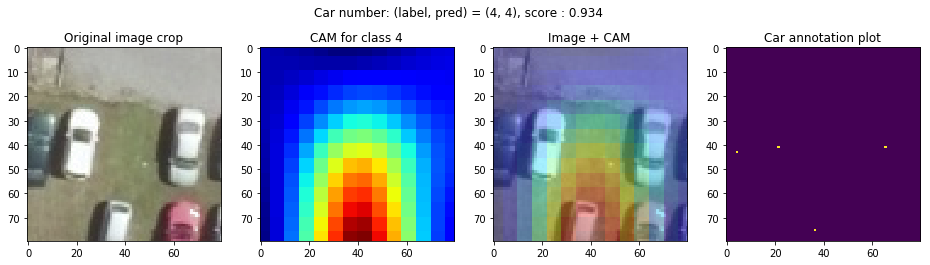

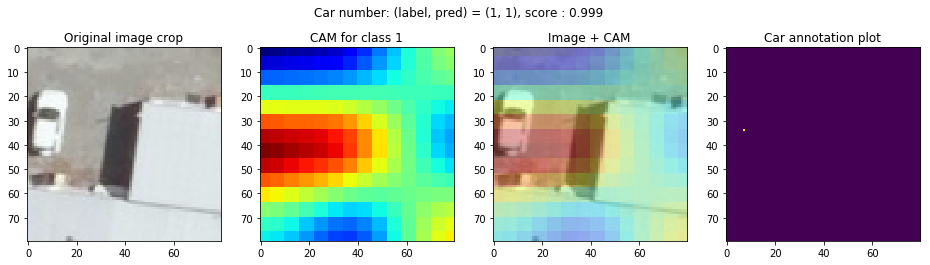

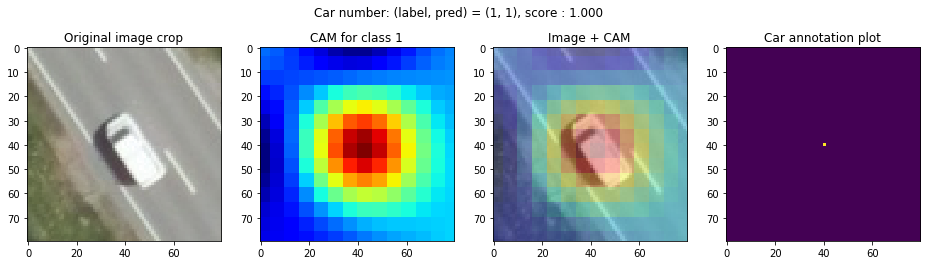

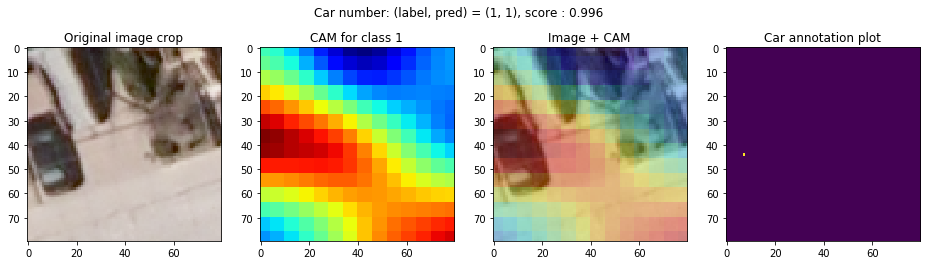

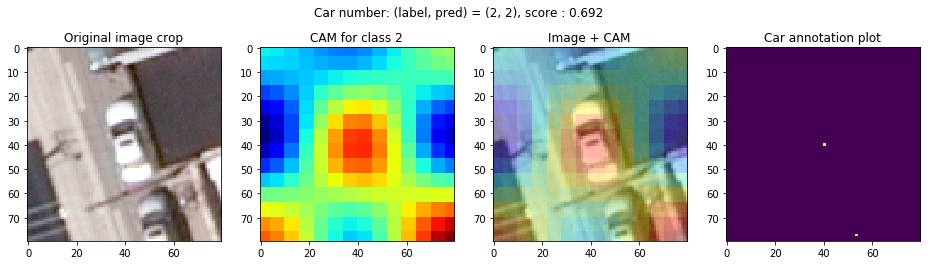

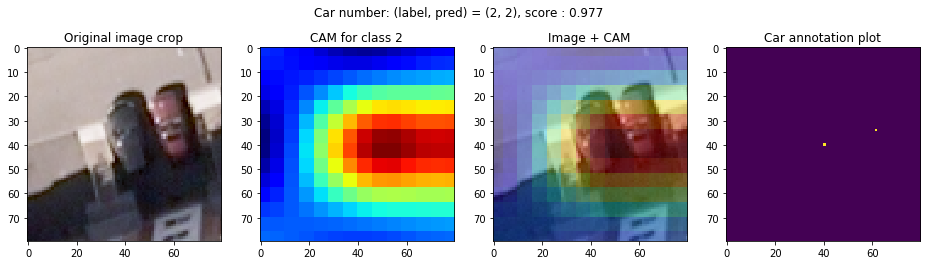

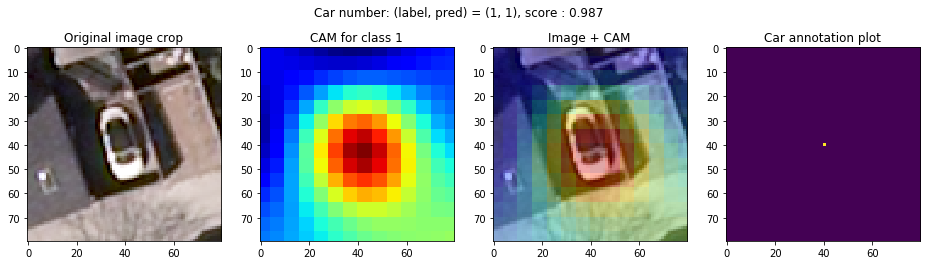

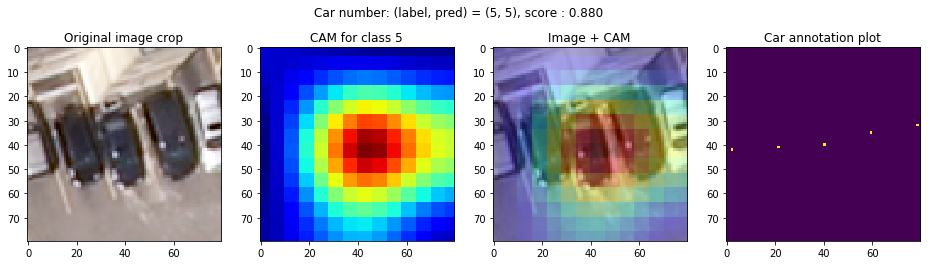

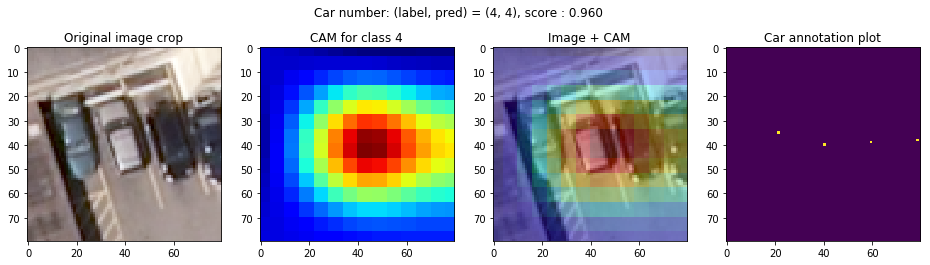

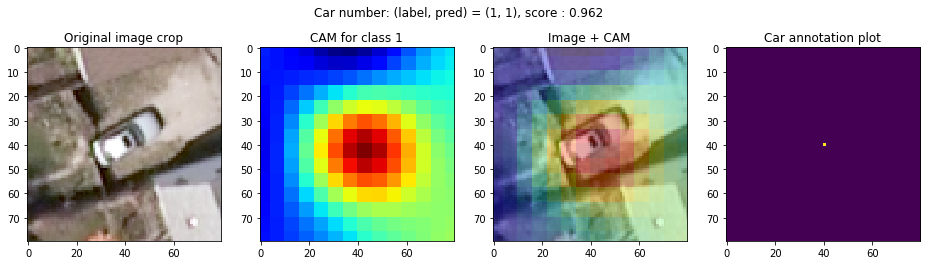

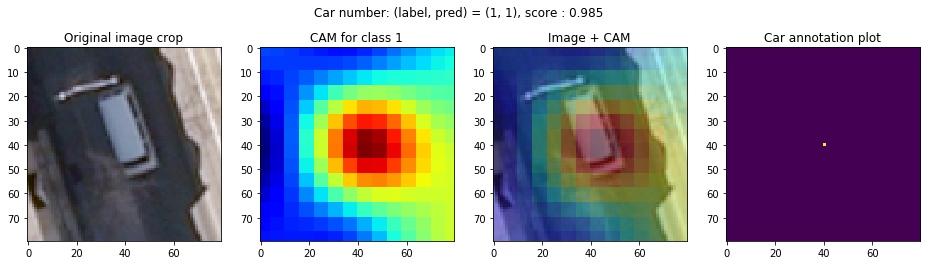

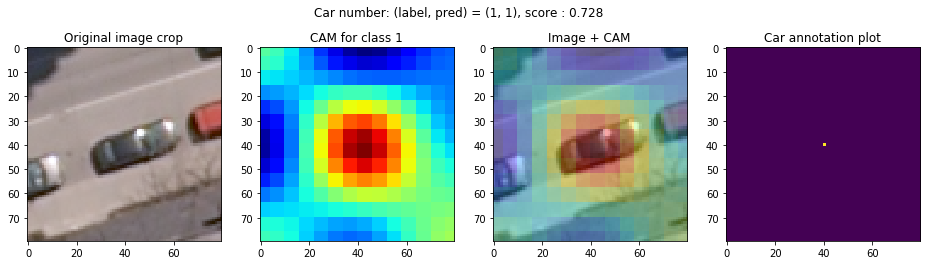

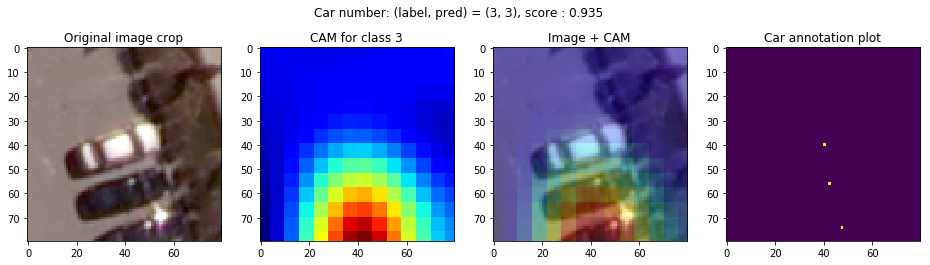

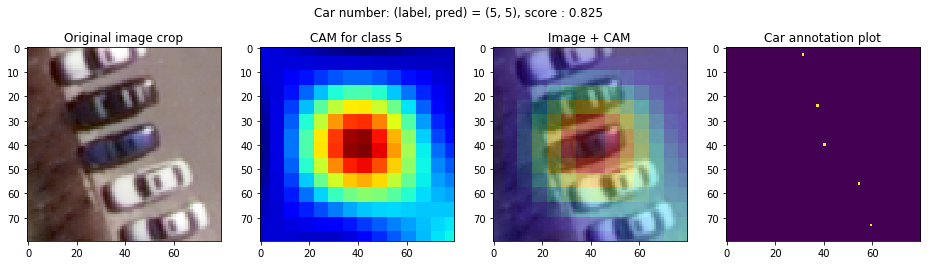

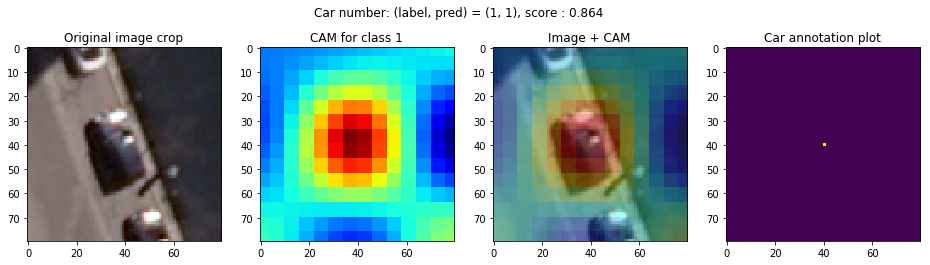

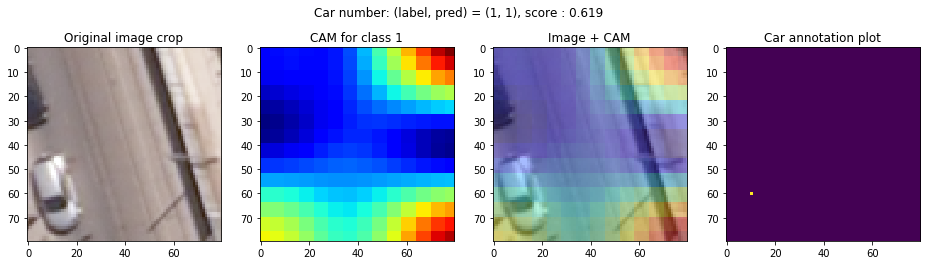

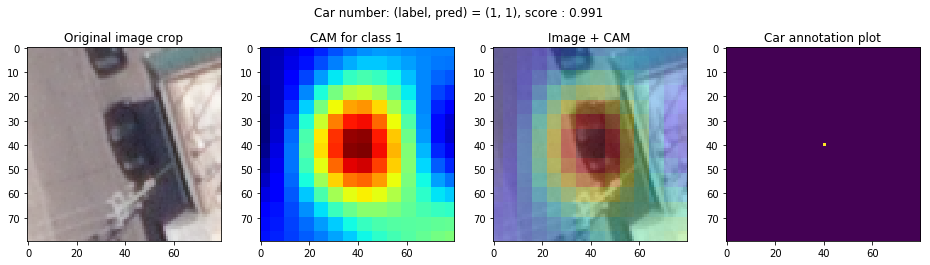

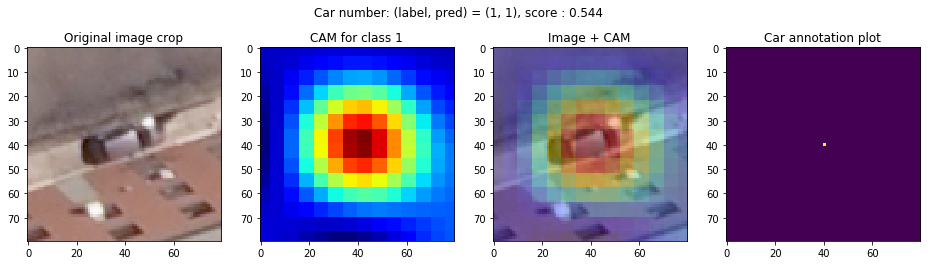

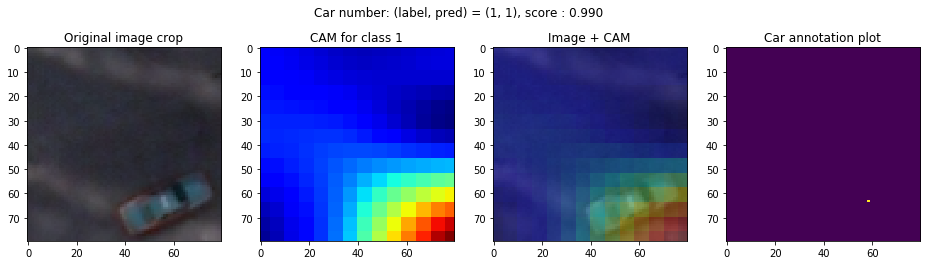

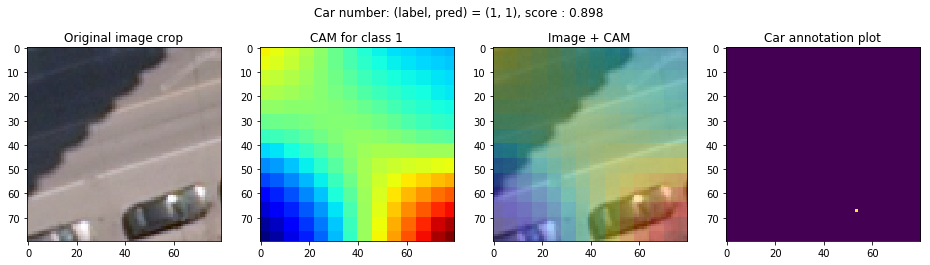

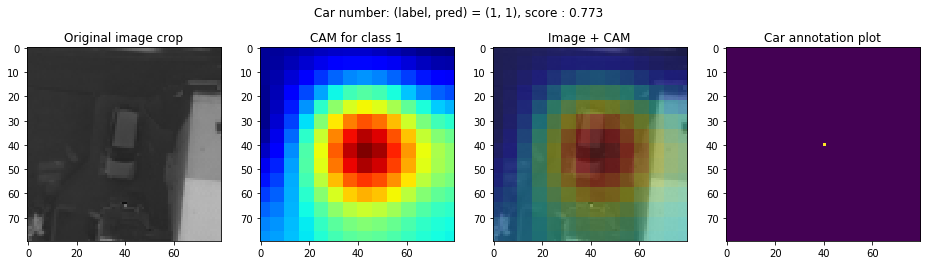

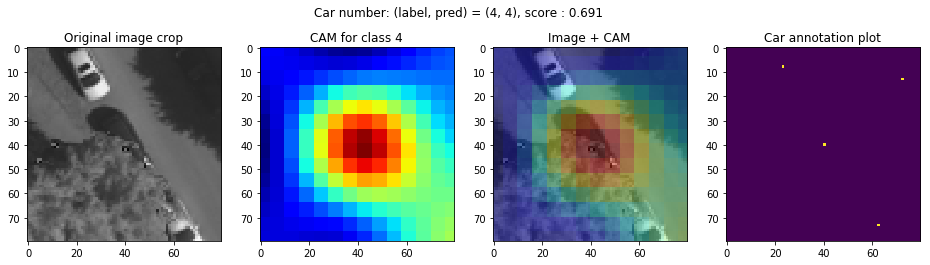

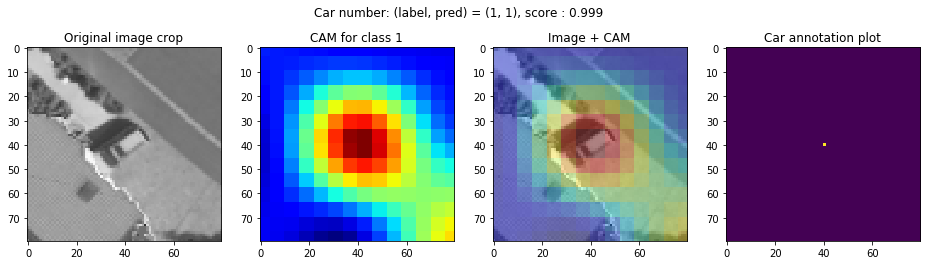

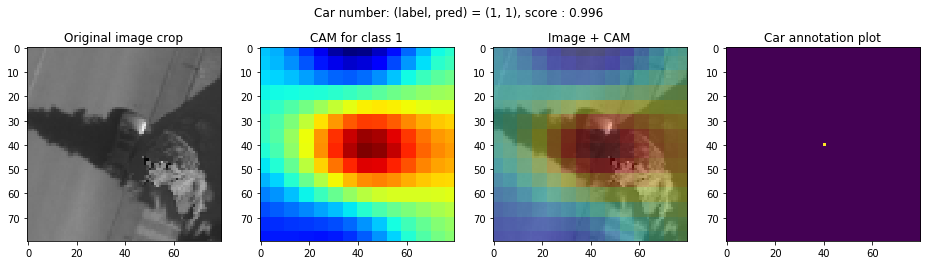

In [5]:
def show_result(image, cam, mask, label, pred, score, figsize=(4 * 4, 4)):
    
    cam = resize_cam(cam[label], dst_size=16)
    
    ignore = count_ignore_width
    cam = cam[ignore:-ignore, ignore:-ignore]
    image = image[ignore:-ignore, ignore:-ignore]
    mask = mask[ignore:-ignore, ignore:-ignore]
    
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=figsize)
    
    ax0.imshow(image)
    ax0.set_title('Original image crop')
    
    ax1.imshow(cam, cmap='jet')
    ax1.set_title('CAM for class {}'.format(label))
    
    ax2.imshow(image)
    ax2.imshow(cam, cmap='jet', alpha=0.35)
    ax2.set_title('Image + CAM')
    
    ax3.imshow(mask)
    ax3.set_title('Car annotation plot'.format(label))
    
    fig.suptitle("Car number: (label, pred) = ({}, {}), score : {:.3f}".format(label, pred, score[label]))
    plt.show()
    

for idx in range(0, len(dataset), 100):
    
    image, label, mask = dataset.get_example(idx)
    
    if label == 0:
        continue
    
    score, cam = model.count(image, compute_cam=True)
    pred = np.argmax(score)
    
    if (pred == 0) or (pred != label):
        continue
    
    show_result(image, cam, mask, label, pred, score)

# Show CAMs on misclassified samples

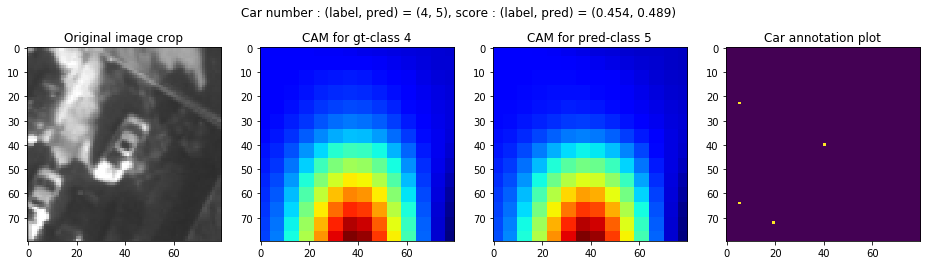

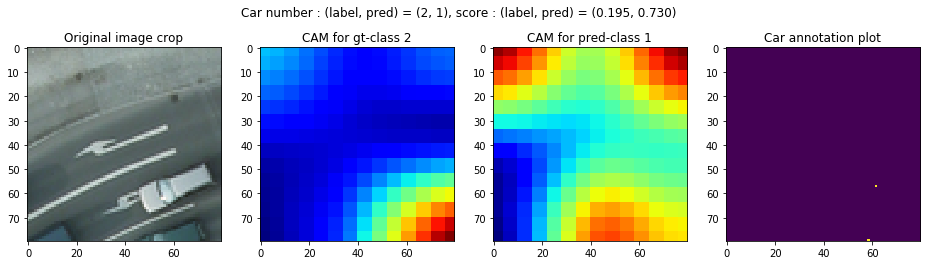

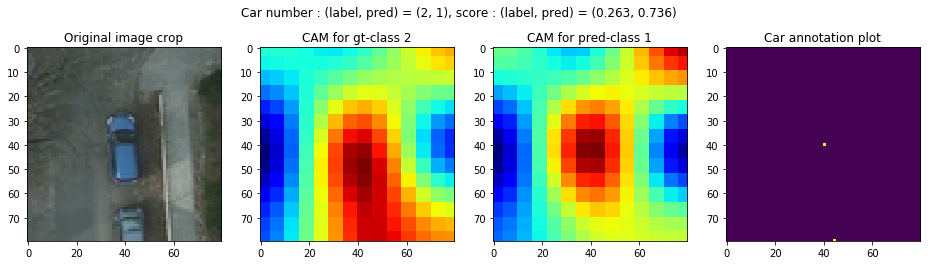

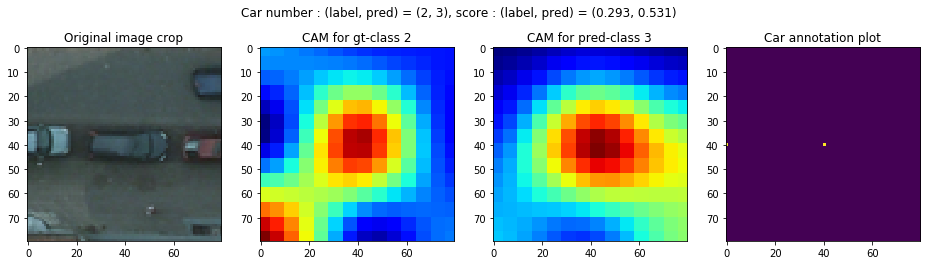

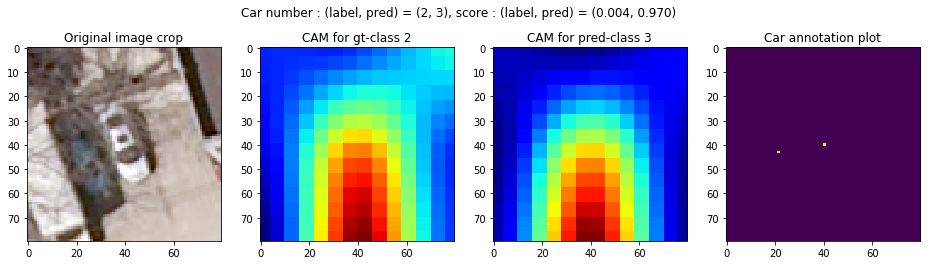

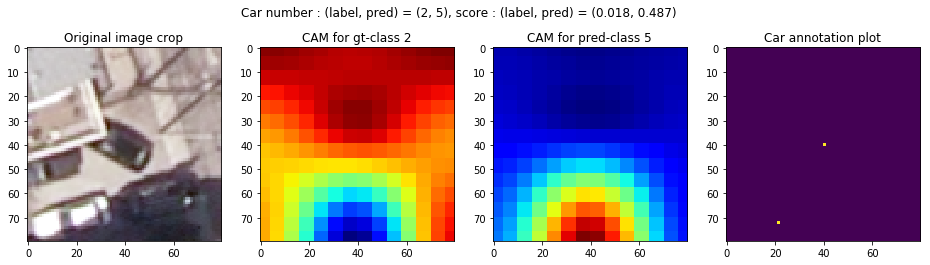

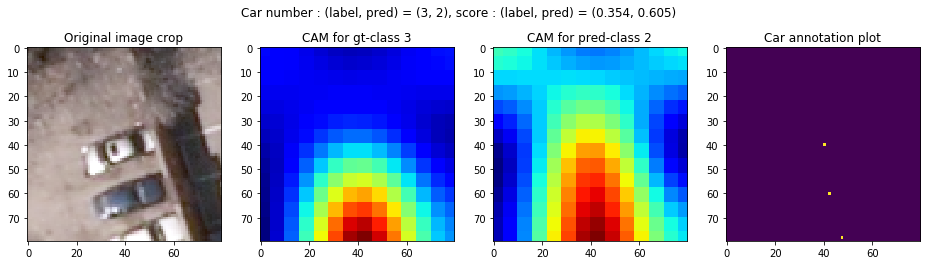

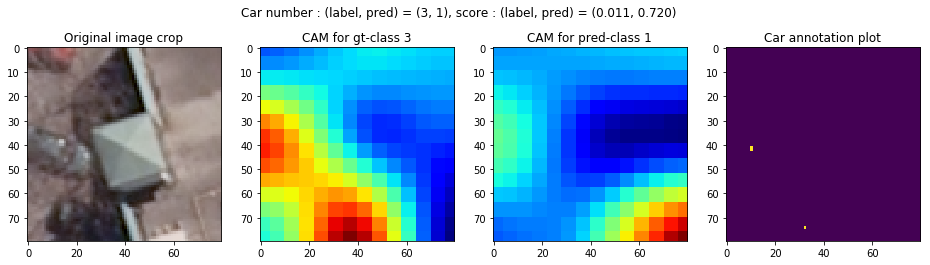

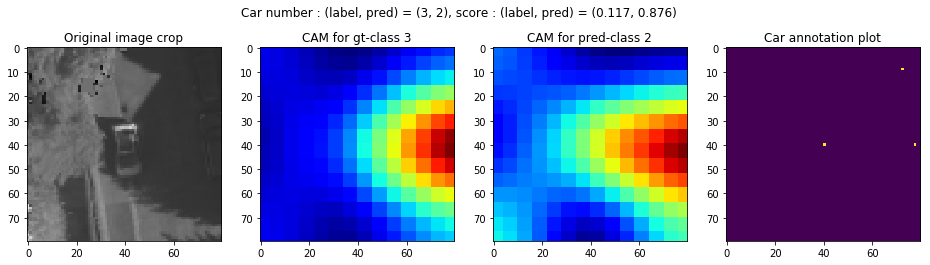

In [6]:
def show_result(image, cam, mask, label, pred, score, figsize=(4 * 4, 4)):
    
    cam_gt = resize_cam(cam[label], dst_size=16)
    cam_pred = resize_cam(cam[pred], dst_size=16)
    
    ignore = count_ignore_width
    cam_gt = cam_gt[ignore:-ignore, ignore:-ignore]
    cam_pred = cam_pred[ignore:-ignore, ignore:-ignore]
    image = image[ignore:-ignore, ignore:-ignore]
    mask = mask[ignore:-ignore, ignore:-ignore]
    
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=figsize)
    
    ax0.imshow(image)
    ax0.set_title('Original image crop')
    
    ax1.imshow(cam_gt, cmap='jet')
    ax1.set_title('CAM for gt-class {}'.format(label))
    
    ax2.imshow(cam_pred, cmap='jet')
    ax2.set_title('CAM for pred-class {}'.format(pred))
    
    ax3.imshow(mask)
    ax3.set_title('Car annotation plot'.format(label))
    
    fig.suptitle("Car number : (label, pred) = ({}, {}), score : (label, pred) = ({:.3f}, {:.3f})".format(label, pred, score[label], score[pred]))
    plt.show()
    

for idx in range(0, len(dataset), 60):
    
    image, label, mask = dataset.get_example(idx)
    
    if label == 0:
        continue
    
    score, cam = model.count(image, compute_cam=True)
    pred = np.argmax(score)
    
    if (pred == 0) or (pred == label):
        continue
    
    show_result(image, cam, mask, label, pred, score)